# Mining Big Data - Assignment 3: Pattern Mining (Basic)
# ================================================

# Notebook 1: Introduction to Pattern Mining with Apriori

## 1. Introduction

This notebook introduces pattern mining techniques for analyzing grocery store transaction data. We'll explore:
- What is pattern mining and why it's useful
- How to preprocess transaction data
- Implementing the Apriori algorithm
- Interpreting the results

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import os

## 3. Load and Explore Data

In [3]:
# Load dataset
train_path = os.path.join('../dataset', 'train.csv')
train_data = pd.read_csv(train_path)

# Display basic information
print(f"Dataset shape: {train_data.shape}")
print(f"Number of unique users: {train_data['User_id'].nunique()}")
print(f"Number of unique items: {train_data['itemDescription'].nunique()}")

# Display first few rows
train_data.head()

Dataset shape: (26985, 7)
Number of unique users: 3493
Number of unique items: 167


,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351.0,1/01/2014,cleaner,2014.0,1.0,1.0,2.0
1,2226.0,1/01/2014,sausage,2014.0,1.0,1.0,2.0
2,1922.0,1/01/2014,tropical fruit,2014.0,1.0,1.0,2.0
3,2943.0,1/01/2014,whole milk,2014.0,1.0,1.0,2.0
4,1249.0,1/01/2014,citrus fruit,2014.0,1.0,1.0,2.0


## 4. Preprocess Data

In [5]:
def preprocess_data(data):
    """Preprocess transaction data for pattern mining."""
    # Make a copy to avoid modifying the original
    df = data.copy()
    
    # Convert date to datetime with dayfirst=True to handle DD/MM/YYYY format
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    
    # Handle missing values
    print(f"Data shape before cleaning: {df.shape}")
    null_counts = df.isnull().sum()
    print("Missing values per column:")
    print(null_counts)
    
    # Drop rows with missing values in critical columns
    df = df.dropna(subset=['itemDescription'])
    print(f"Data shape after cleaning: {df.shape}")
    
    return df

# Preprocess data
preprocessed_data = preprocess_data(train_data)

Data shape before cleaning: (26985, 7)
Missing values per column:
User_id            7603
Date               7603
itemDescription    7603
year               7603
month              7603
day                7603
day_of_week        7603
dtype: int64
Data shape after cleaning: (19382, 7)


## 5. Create Transaction Lists

In [6]:
def create_transaction_lists(data):
    """Convert dataframe to transaction lists format."""
    # Group by transaction ID and aggregate items
    transactions = data.groupby('User_id')['itemDescription'].apply(list).to_dict()
    
    print(f"Created {len(transactions)} transactions")
    
    return transactions

# Create transaction lists
transaction_data = create_transaction_lists(preprocessed_data)

# View a sample transaction
sample_user_id = list(transaction_data.keys())[0]
print(f"Sample transaction for user {sample_user_id}:")
print(transaction_data[sample_user_id])

Created 3493 transactions
Sample transaction for user 1000.0:
['whole milk', 'pastry', 'salty snack']


## 6. Encode Transactions

In [7]:
# Create clean transaction lists
cleaned_transactions = []
for transaction in transaction_data.values():
    # Remove any NaN values from the transaction
    cleaned_transaction = [item for item in transaction if isinstance(item, str) and pd.notna(item)]
    # Only add non-empty transactions
    if cleaned_transaction:
        cleaned_transactions.append(cleaned_transaction)

print(f"Prepared {len(cleaned_transactions)} transactions")

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(cleaned_transactions).transform(cleaned_transactions)
encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded {len(cleaned_transactions)} transactions with {len(te.columns_)} unique items.")

Prepared 3493 transactions
Encoded 3493 transactions with 167 unique items.


## 7. Apply Apriori Algorithm

In [16]:
# Run Apriori algorithm
min_support = 0.01  # Items must appear in at least 1% of transactions
print(f"Running Apriori algorithm with min_support={min_support}...")

start_time = time.time()
frequent_itemsets = apriori(
    encoded_data, 
    min_support=min_support, 
    use_colnames=True,
    verbose=1
)
execution_time = time.time() - start_time

print(f"Found {len(frequent_itemsets)} frequent itemsets")
print(f"Execution time: {execution_time:.2f} seconds")

# Display top frequent itemsets by support
frequent_itemsets.sort_values('support', ascending=False).head(10)

Running Apriori algorithm with min_support=0.01...
Processing 96 combinations | Sampling itemset size 4 3
Found 383 frequent itemsets
Execution time: 0.06 seconds


,support,itemsets
97,0.270255,(whole milk)
62,0.227025,(other vegetables)
75,0.222159,(rolls/buns)
84,0.206413,(soda)
98,0.173204,(yogurt)
7,0.139708,(bottled water)
76,0.135127,(root vegetables)
82,0.121386,(shopping bags)
92,0.113656,(tropical fruit)
65,0.111938,(pastry)


## 8. Generate Association Rules

In [17]:
# Generate association rules
min_confidence = 0.1  # 50% confidence threshold
min_lift = 1.0        # Only rules with lift > 1.0 (positive correlation)

rules = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=min_confidence
)
rules = rules[rules['lift'] >= min_lift]

print(f"Generated {len(rules)} association rules")

# Display top rules sorted by lift
rules.sort_values('lift', ascending=False).head(10)

Generated 409 association rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
393,"(other vegetables, yogurt)",(shopping bags),0.046092,0.121386,0.010306,0.223602,1.842084,1.0,0.004711,1.131655,0.479225,0.065574,0.116339,0.154254
392,"(shopping bags, other vegetables)",(yogurt),0.032637,0.173204,0.010306,0.315789,1.823227,1.0,0.004654,1.208395,0.466755,0.052709,0.172456,0.187647
391,"(shopping bags, yogurt)",(other vegetables),0.027484,0.227025,0.010306,0.375000,1.651797,1.0,0.004067,1.236759,0.405750,0.042204,0.191435,0.210199
374,"(rolls/buns, newspapers)",(whole milk),0.023189,0.270255,0.010306,0.444444,1.644539,1.0,0.004039,1.313541,0.401231,0.036400,0.238699,0.241290
149,(dessert),(tropical fruit),0.053822,0.113656,0.010020,0.186170,1.638017,1.0,0.003903,1.089103,0.411662,0.063636,0.081813,0.137166
259,(pastry),(pip fruit),0.111938,0.084168,0.015173,0.135550,1.610462,1.0,0.005752,1.059438,0.426840,0.083861,0.056104,0.157911
258,(pip fruit),(pastry),0.084168,0.111938,0.015173,0.180272,1.610462,1.0,0.005752,1.083362,0.413897,0.083861,0.076947,0.157911
196,(hard cheese),(soda),0.032064,0.206413,0.010593,0.330357,1.600468,1.0,0.003974,1.185090,0.387611,0.046482,0.156182,0.190837
375,(newspapers),"(whole milk, rolls/buns)",0.095047,0.067850,0.010306,0.108434,1.598139,1.0,0.003857,1.045520,0.413582,0.067542,0.043538,0.130166
372,"(whole milk, rolls/buns)",(newspapers),0.067850,0.095047,0.010306,0.151899,1.598139,1.0,0.003857,1.067034,0.401515,0.067542,0.062823,0.130166


## 9. Visualize Results

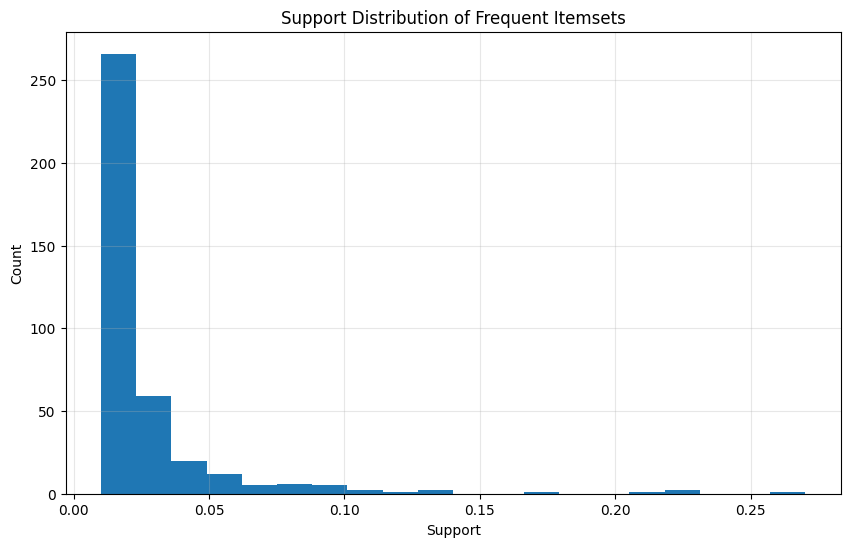

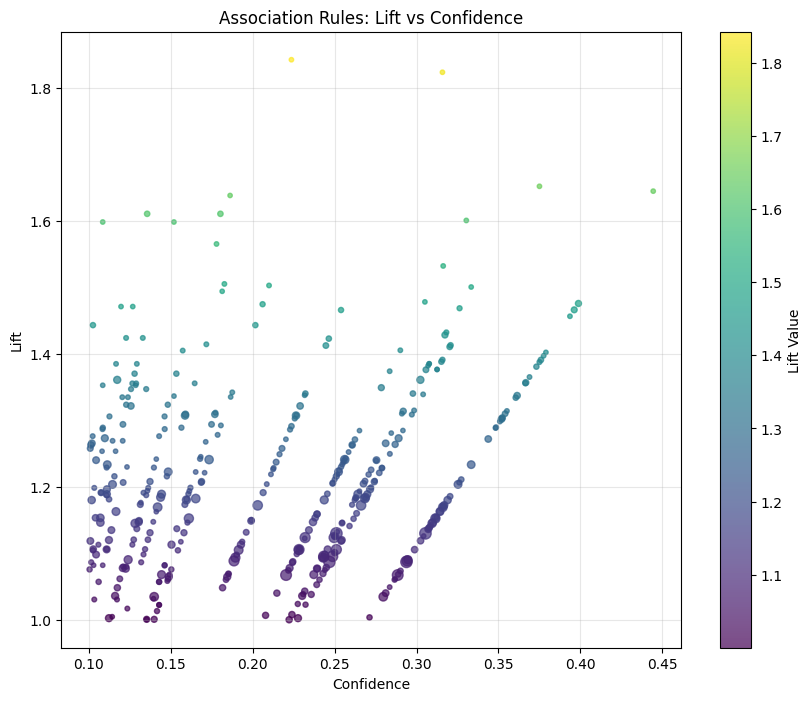

In [18]:
# Plot support distribution
plt.figure(figsize=(10, 6))
plt.hist(frequent_itemsets['support'], bins=20)
plt.title('Support Distribution of Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Plot lift vs confidence for rules
if len(rules) > 0:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        rules['confidence'],
        rules['lift'],
        alpha=0.7,
        s=rules['support']*1000,
        c=rules['lift'],
        cmap='viridis'
    )
    plt.colorbar(scatter, label='Lift Value')
    plt.title('Association Rules: Lift vs Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.grid(True, alpha=0.3)
    plt.show()

## 10. Interpret Results

In [19]:
# Add readable format for better interpretation
if len(frequent_itemsets) > 0:
    frequent_itemsets['itemsets_str'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))
    
    # Print multi-item sets (length > 1)
    print("\nTop frequent itemsets with multiple items:")
    multi_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 1]
    multi_itemsets = multi_itemsets.sort_values('support', ascending=False)
    
    for i, row in multi_itemsets.head(10).iterrows():
        print(f"Support: {row['support']:.4f}, Items: {row['itemsets_str']}")

# Print top rules in readable format
if len(rules) > 0:
    print("\nTop association rules by lift:")
    rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
    
    for i, row in rules.sort_values('lift', ascending=False).head(10).iterrows():
        print(f"Lift: {row['lift']:.4f}, Confidence: {row['confidence']:.4f}, Support: {row['support']:.4f}")
        print(f"Rule: {row['antecedents_str']} -> {row['consequents_str']}")
        print("-" * 50)


Top frequent itemsets with multiple items:
Support: 0.0678, Items: whole milk, rolls/buns
Support: 0.0667, Items: whole milk, other vegetables
Support: 0.0595, Items: soda, whole milk
Support: 0.0553, Items: rolls/buns, other vegetables
Support: 0.0518, Items: soda, other vegetables
Support: 0.0515, Items: soda, rolls/buns
Support: 0.0510, Items: whole milk, yogurt
Support: 0.0461, Items: other vegetables, yogurt
Support: 0.0435, Items: whole milk, bottled water
Support: 0.0421, Items: rolls/buns, yogurt

Top association rules by lift:
Lift: 1.8421, Confidence: 0.2236, Support: 0.0103
Rule: other vegetables, yogurt -> shopping bags
--------------------------------------------------
Lift: 1.8232, Confidence: 0.3158, Support: 0.0103
Rule: shopping bags, other vegetables -> yogurt
--------------------------------------------------
Lift: 1.6518, Confidence: 0.3750, Support: 0.0103
Rule: shopping bags, yogurt -> other vegetables
--------------------------------------------------
Lift: 1.64

## 11. Conclusion

In this notebook, we've learned:
- How to preprocess and encode transaction data
- How to apply the Apriori algorithm for discovering frequent itemsets
- How to generate association rules from frequent itemsets
- How to interpret and visualize the results

In the next notebook, we'll explore the FP-Growth algorithm for more efficient pattern mining.